## 1 Counting paths in graphlets

In [2]:
import numpy as np
import igraph as ig

#create the depicted graphs unter 1.2)
g1 = ig.Graph()
g1.add_vertices(4)
g1.add_edges([(0,1),(1,2),(1,3),(2,3)])
#print(g1)

g2 = ig.Graph()
g2.add_vertices(4)
g2.add_edges([(0,1),(1,2),(1,3),(2,3),(0,3)])
#print(g2)

g3 = ig.Graph()
g3.add_vertices(5)
g3.add_edges([(0,2),(0,3),(1,2),(2,3),(3,4),(1,4)])
#print(g3)

g4 = ig.Graph()
g4.add_vertices(5)
g4.add_edges([(0,4),(1,4),(1,3),(1,2),(2,3),(3,4)])
#print(g4)

g5 = ig.Graph()
g5.add_vertices(5)
g5.add_edges([(0,1),(1,2),(2,3),(3,4),(4,0),(0,2),(2,4),(1,3)])
#print(g5)


In [1]:
#1.1)
#implement DFS
def init_algo(g):
    #for every start node, span a new directed tree and sum the count of "complete" paths 
    sum = 0
    for v in g.vs:
        c = ig.Graph() #create a new empty graph c
        c.to_directed() 
        n = 0
        c.add_vertices(1) #add the base vertex
        c.vs[n]['num']=v.index #label it the its index in graph g
        count_paths(g,c,n)
        
        #get the in-neighboorhood (order = #node if graph g) of each node in graph c and store it in an array.
        #where we have a size of the neighborhood = the node count of graph g: we know that this path connect all nodes
        res = np.where(np.array([len(v) for v in c.neighborhood(c.vs,order=g1.vcount(),mode='in')]) == g.vcount(),1,0)
        sum += np.sum(res) #get only those "complete" paths 
    return sum
    
def count_paths(g,c,n): 
    #get all predecessors of the current lastly added node and get their labels (not indices!)
    pred = c.neighborhood(c.vs[n],order=g.vcount(),mode="in")
    pred = np.array([c.vs[v]['num'] for v in pred])
    #for each neighbor of the current node in g check whether it was already part of the new path in c.
    for neigh in g.neighbors(g.vs[c.vs[n]['num']]):
        cut = False   
        if neigh in pred: #if it was in the path in c already, cut branch
            cut = True
        if not cut: #otherwise, add it as a new node with the correct label and continue with its neighbors in graph g
            c.add_vertices(1)
            c.add_edges([(n,c.vcount()-1)])        
            c.vs[c.vcount()-1]['num'] = neigh
            count_paths(g,c,c.vcount()-1)

In [4]:
#1.2
#count possible paths:
count = init_algo(g1)
print("g1 path count: ",count/2)

count = init_algo(g2)
print("g2 path count: ",count/2)

count = init_algo(g3)
print("g3 path count: ",count/2)

count = init_algo(g4)
print("g4 path count: ",count/2)

count = init_algo(g5)
print("g5 path count: ",count/2)

g1 path count:  2.0
g2 path count:  6.0
g3 path count:  7.0
g4 path count:  4.0
g5 path count:  24.0


## 2 Sampled harmonic closeness centrality

In [59]:
import igraph as ig
import numpy as np
from numpy import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [60]:
# 2.1
def SCC(g, landmarks, vertices):
    # get lenghts of shortest path for each vertex-landmark pair
    path_len = g.shortest_paths(vertices, landmarks, mode='all')
    # cast as numpy array
    dist = np.stack(path_len).astype(float)
    
    # in case a vertex is in landmarks:
    # set its dist value to inf s.t. the inverse is 0
    dist[dist == 0] = np.inf
    # subtract 1 from the number of landmarks
    is_vert_in_landmarks = np.in1d(vertices, landmarks).astype(float)
    
    # normalize by number of landmarks
    norm = len(landmarks) - is_vert_in_landmarks
    # compute the normalized sum of inverse distances
    result = np.sum(1 / dist, axis=1) / norm
    return result



In [82]:
#2.2
# load the graph as undirected
g = ig.Graph.Read_Pickle('ogbn-arxiv.pickle').as_undirected()

# get vertices with label '12'
subg_vertices = [v.index for v in g.vs.select(label_eq=12)]

alpha_list = [0.001, 0.01, 0.1, 1]
n_runs = 30

result = np.zeros((len(alpha_list), len(subg_vertices), n_runs))
for idx, alpha in enumerate(tqdm(alpha_list, desc='total')):
    n_landmarks = int(alpha * g.vcount())

    for r in tqdm(range(n_runs), desc=f'alpha={alpha}'):
        # select random landmark node indices - part of graph G
        landmarks = random.choice(np.arange(g.vcount()), n_landmarks, replace=False)
        
        close_centr = SCC(g, landmarks, subg_vertices)
        result[idx, :, r-1] = close_centr

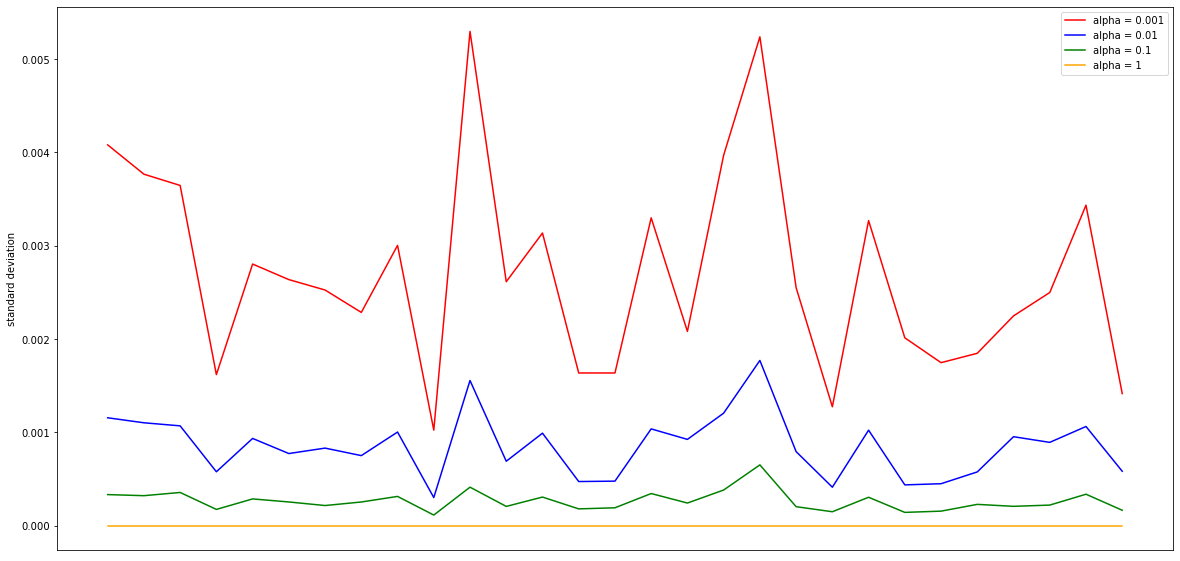

In [101]:
# get mean and standard deviation for each alpha
mean = np.mean(result, axis=2)
std_dev = np.sqrt(np.mean((result - mean[:, :, np.newaxis])**2, axis=2))

colors = ['red', 'blue', 'green', 'orange']
plt.figure(figsize=(20, 10))

for idx, alpha in enumerate(alpha_list):
    plt.plot(range(len(subg_vertices)), std_dev[idx], c=colors[idx], label=f'alpha = {alpha}')
plt.legend()
plt.xticks([])
plt.ylabel('standard deviation')
plt.show()

## 3 Degeneracy

In [72]:
import igraph
import numpy as np

In [81]:
# load the graph as undirected
g = igraph.Graph.Read_Pickle('ogbn-arxiv.pickle').as_undirected()

In [82]:
def degeneracy(g):
    # get adjacency list
    adj = g.get_adjlist()
    # create result array
    deg = np.zeros((g.vcount()))
    # create A
    arrA = [[] for _ in range(g.vcount())]
    # create B and init with degreee of each vertex
    arrB = g.degree(range(g.vcount()))
    # fill A with lists of vertices that have each degree
    for i, degree in enumerate(arrB):
        arrA[degree].append(i)
    
    # loop over all degrees 
    k = d_min = 0        
    while d_min < g.vcount():
        # if there are no vertices with degree d_min, consider d_min + 1
        if arrA[d_min] == []:
            d_min += 1
        # otherwise, consider a vertex with degree d_min
        else:
            # remove the vertex from A
            vertex = arrA[d_min].pop()
            # for each neighbor of A
            for neigh in adj[vertex]:
                # find its degree
                neigh_degree = arrB[neigh]
                # move the neighbor in A to its new degree list
                arrA[neigh_degree].remove(neigh)
                arrA[neigh_degree - 1].append(neigh)
                # decrease its degree in B
                arrB[neigh] -= 1
                # remove vertex from the adjacency list of its neighbor
                adj[neigh].remove(vertex)
            # compute the coreness of the vertex
            k = max(k, d_min)
            deg[vertex] = k
            # decrease d_min to consider possible ex-neighbors of vertex
            d_min -= 1
            
    return deg

In [83]:
deg = degeneracy(g)

In [84]:
# check if implementation gives the correct result
is_correct = np.all(np.equal(deg, g.coreness()))
print(f'implementation is correct: {is_correct}')

implementation is correct: True
